# Interpolation

Here we will perform a quick exploration of some of the interpolation routines available in `scipy.interpolate`.  As always there is much more available than we will use here.  You should explore some of the other functions on your own.

## Initialization

As always we load all the modules we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Documentation

Again as always we should explore the documentation to learn more about the functions that are available for us.  We will only be interested in univariate interpolation, though there are functions for higher dimensional interpolations available.  The main functions to focus on are `lagrange`, `interp1d`, and `InterpolatedUnivariateSpline`.

In [ ]:
interp?

In [ ]:
interp.lagrange?

In [ ]:
interp.interp1d?

In [ ]:
interp.InterpolatedUnivariateSpline?

The main things to pay attention to while looking at these functions are
1. what they do,
2. how they are called, including optional arguments,
3. constraints on the arguments, that is, any special conditions that must be satisfied,
4. what they return and any constraints on them.

## Simple Tests

Here we will compare polynomial interpolation with a cubic spline.  It is interesting to vary the number of points, `N`, and see how the two methods compare.  We might expect that for very few points interpolation does a poor job since not much structure about the function we are interpolating is known.  As the number of points is increased it may be expected that interpolation does a better job.  To an extent this is true, however as `N` gets somewhat large (say near 20 or so) the polynomial interpolation can fail spectacularly.  Evaluating a high order polynomial is not easy due to the limited precision of computers.  The spline **does improve** as `N` increases since it is doing a piecewise interpolation.

Note that we do not use `interp1d` since it does not allow for extrapolation (see below).

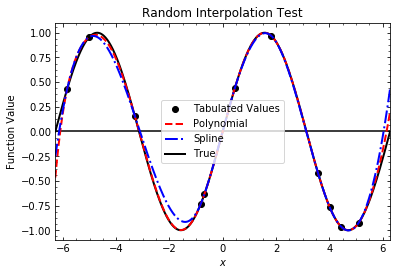

In [2]:
N = 11 # Number of points to generate
xmax = 2*np.pi
x = (2*np.random.rand(N)-1)*xmax
x.sort() # We need the x values to be monotonic, so sort them
y = np.sin(x)

# Use polynomial interpolation and a spline
ypoly = interp.lagrange(x,y)
yspline = interp.InterpolatedUnivariateSpline(x,y)

# For plotting purpose we generate a fine grid
xx = np.linspace(-xmax, xmax, 1000)
ytrue = np.sin(xx)

# Now make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.plot(x, y, 'ko', label='Tabulated Values')
ax.plot(xx, ypoly(xx), 'r--', lw=2, label='Polynomial')
ax.plot(xx, yspline(xx), 'b-.', lw=2, label='Spline')
ax.plot(xx, ytrue, 'k-', lw=2, zorder=-1, label='True')
ax.set_xlim(xx[0], xx[-1])
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel('Function Value')
ax.set_title('Random Interpolation Test');
#ax.set_ylim(-4,4);

In [3]:
print(ypoly)

           10             9             8             7             6
-5.76e-08 x  + 1.476e-06 x + 4.229e-06 x - 0.0001744 x - 9.682e-05 x
             5            4          3             2
 + 0.008199 x + 0.000715 x - 0.1667 x - 0.0009642 x + 0.9999 x + 0.0002157


Overall we find for "moderate" values of `N` both the polynomial and spline work well where the function is well sampled, though the polynomial often better reprents the true function.  In places where it is not or at the ends when the interpolants are extrapolated neither tend to perform well.  This is generic issue with interpolation!

## Inverting a Function

A very powerful use of interpolation is to invert a function.  We typically think of a function as $y = f(x)$, given $x$ we wish to calculate $y$.  With interpolation, we start with tabulated values for $x$ and $y$ and estimate values of the function at $x$ values in between the tabulated ones.  However, we can just as well invert this and instead consider $x=f^{-1}(y)$.  This is *exactly the same problem* just with the roles of $x$ and $y$ reversed.

Here we will consider inverting a simple function: $y=\mathrm{e}^{-x/3}$.  We know the result in this case, $x=-3\ln(y)$.

First define our function and its inverse.

In [4]:
def f(x) :
    return np.exp(-x/3.)
def finv(y) :
    return -3.*np.log(y)

Next we perform a simple test to verify that interpolation does a good job of representing our function.  Since this is a quick test we use a "quick plot" and do not make it look nice.

Maximum fractional error = 0.017842407358764967


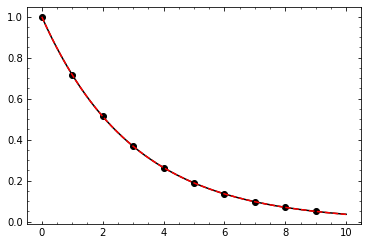

In [5]:
x = np.arange(10.)
y = f(x)
yspline = interp.InterpolatedUnivariateSpline(x,y)
xx = np.linspace(0, 10, 1000)
ytrue = f(xx)
plt.plot(x, y, 'ko')
plt.plot(xx, ytrue, 'k-')
plt.plot(xx,yspline(xx), 'r--')
print("Maximum fractional error =", np.abs(1-yspline(xx)/ytrue).max())

Since that works let us try to use a spline to invert the function.  As noted about this just means swapping $x$ and $y$.

In [ ]:
yinvspline_fail = interp.InterpolatedUnivariateSpline(y,x)

It fails to run.  This is an improvement in recent versions of `scipy.interpolate`!  In the past it would silently create the spline, but then for *some values* of `y` it would return `nan`!  It even tells us why it failed.

To understand what is happening go back to the documenation for `InterpolatedUnivariateSpline`.  Notice that the first argument **must be increasing**.  This is a peculiar limitation of the interface provided by `scipy.interpolate`.  Regardless, it is documented and if you check our `y` array you will find it is actually decreasing, not increasing.  Thus we need to invert the order of the array.  How do we do this?

A very powerful feature of array processing languages such as the one provided by NumPy is *array slicing*.  We will have more to say about this in the future but for now we will note that when accessing the elements of an array we can use
> `y[start:stop:step]`

to get a view of a subset of the array.  This is similar to using `arange` to generate a list of index values inside the square brackets (similar, but not the same).

For our purposes we want to reverse the order of the array and will leave the details for the future.  This means we want to start at the end of the array and step backwards through it to get to the beginning.  The shorthand way to do this is `y[::-1]`.

First verify this actually works.

In [6]:
print('y =', y)
print('y[::-1] =', y[::-1])

y = [1.         0.71653131 0.51341712 0.36787944 0.26359714 0.1888756
 0.13533528 0.09697197 0.06948345 0.04978707]
y[::-1] = [0.04978707 0.06948345 0.09697197 0.13533528 0.1888756  0.26359714
 0.36787944 0.51341712 0.71653131 1.        ]


Now use this to construct a spline of the inverted function.  Note that since we are inverting the order of `y` we must also invert the order of `x`!  This now works much better.

In [7]:
yinvspline = interp.InterpolatedUnivariateSpline(y[::-1], x[::-1])
ytry = 0.2
print('For y =', ytry, 'true inverse is', finv(ytry), 'and our spline gives', yinvspline(ytry))

For y = 0.2 true inverse is 4.828313737302301 and our spline gives 4.8283336871512965


We can create a quick plot to verify it works over a broader range of values.

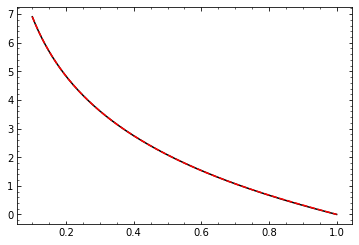

In [8]:
yy = np.linspace(0.1, 1, 1000)
plt.plot(yy, finv(yy), 'k-')
plt.plot(yy, yinvspline(yy), 'r--')

## `interp1d`

We have not used `interp1d` in this notebook.  There is nothing wrong with using `interp1d`, it has its own set of features and its own issues.  It provides a different interface for performing piecewise polynomial interpolations (and splines).  One "feature" it has is that it does **not** allow you to extrapolate.  This is good and bad.  Since extrapolation is dangerous it prevents you from accidentally extrapolating. (Recall that we can ask a computer to do anything and it will calculate away, even if such a calculation does not make sense.  Here `interp1d` protects us from accidentally making one mistake.)  For our purposes above we wanted to extrapolate so we could see what happens.

To see this in practice consider the following.  Notice that we get an error when we ask for a value outside our input range.

In [9]:
x = np.arange(10)
y = np.exp(-x)
yinterp = interp.interp1d(x, y, kind='cubic') # This creates a cubic spline

In [10]:
# This should work fine
yinterp(5.5)

array(0.00406393)

In [11]:
# This should produce an error
yinterp(10.5)

ValueError: A value in x_new is above the interpolation range.